# Análisis de series temporales

## Introducción

### Propósito del proyecto

<!-- TODO: Explicar el propósito del proyecto -->
En este proyecto de ciencia de datos se desarrollarán técnicas de regresión mediante series temporales (_time series_) con el objetivo de intentar predecir el precio de acciones en bolsa de diferentes empresas farmacéuticas.

En concreto se desea predecir el precio de las acciones de la farmacéutica _Pfizer_ utilizando un conjunto de datos con registros de los últimos 5 años (2019-2024). Para ayudar a la predicción, se cuentan también con información de las siguientes compañías farmacéuticas:

* _Moderna_
* _AstraZeneca_
* _Johnson & Johnson_

Esta información adicional se utilizará para comprobar posibles relaciones entre las subidas o valores de las otras empresas frente al estado de las acciones de _Pfizer_.

Debido al comportamiento impredecible de la bolsa en corto plazo, se propone realizar una predicción a medio plazo, buscando predecir los precios de las acciones cada semana/dos semanas en vez de de manera diaria. Este punto será desarrollado más adelante.

Para este estudio se ha planteado utilizar tres tipos de modelos de series temporales:

* Series temporales univariadas.
* Series temporales multivariadas.
* Series temporales sobre datos de tipo panel.

Esta información ha sido extraída del sitio web [Yahoo Finance](https://finance.yahoo.com/).

### Librerías utilizadas

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Descripción de los conjuntos de datos utilizados

<!-- TODO: Explicar conjuntos de datos utilizados -->
Los conjuntos de datos se encuentra almacenados en los siguientes ficheros _.csv_:

* `AZN.csv` (_AstraZeneca_)
* `JNJ.csv` (_Johnson & Johnson_)
* `MRNA.csv` (_Moderna_)
* `PFE.csv` (_Pfizer_)

Al tratarse de datos de valores en bolsa, la estructura de todos los conjuntos de datos es la misma en todos los ficheros:

|Campo|Definición|
|-|-|
|`Date`|Fecha de registro de precios|
|`Open`|Precio inicial al momento del registro|
|`High`|Precio más alto a lo largo del día|
|`Low` |Precio más bajo a lo largo del día|
|`Close`|Precio de cierre al final del día|
|`Adj Close`|Precio de cierre ajustado al final del día|
|`Volume`|Número de acciones vendidas|

In [117]:
pfizer_data = pd.read_csv('../data/input/stock/PFE.csv')

display(pfizer_data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-10,41.024670,41.024670,40.483871,40.863377,33.336327,15275727
1,2019-06-11,40.986717,41.081593,40.370018,40.483871,33.026730,18813162
2,2019-06-12,40.294117,40.958256,40.284630,40.872864,33.344067,16296843
3,2019-06-13,40.863377,40.929790,40.199242,40.322582,32.895149,14464042
4,2019-06-14,40.341557,40.673622,40.303604,40.569260,33.096386,13197872


In [118]:
azeneca_data = pd.read_csv('../data/input/stock/AZN.csv')

display(azeneca_data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-10,39.160000,39.720001,39.080002,39.590000,34.930904,2928900
1,2019-06-11,39.689999,39.740002,39.310001,39.389999,34.754440,2378100
2,2019-06-12,39.520000,39.990002,39.520000,39.930000,35.230892,2507300
3,2019-06-13,39.810001,40.009998,39.599998,39.910000,35.213245,2020000
4,2019-06-14,39.680000,39.959999,39.619999,39.669998,35.001492,1477800


In [119]:
jnj_data = pd.read_csv('../data/input/stock/JNJ.csv')

display(jnj_data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-10,138.600006,139.149994,137.600006,139.020004,121.157661,4994700
1,2019-06-11,139.679993,140.660004,139.500000,139.779999,121.819977,8230500
2,2019-06-12,140.300003,142.910004,140.300003,141.679993,123.475845,9216500
3,2019-06-13,141.720001,141.949997,140.210007,140.710007,122.630539,7500800
4,2019-06-14,141.229996,141.490005,140.039993,140.089996,122.090157,6548100


In [120]:
moderna_data = pd.read_csv('../data/input/stock/MRNA.csv')

display(moderna_data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-10,17.850000,17.990000,15.670000,15.670000,15.670000,2574700
1,2019-06-11,16.090000,16.879999,15.750000,16.000000,16.000000,5614200
2,2019-06-12,16.110001,16.360001,15.620000,16.299999,16.299999,2042400
3,2019-06-13,16.420000,17.590000,16.049999,16.160000,16.160000,1607300
4,2019-06-14,16.250000,16.674999,15.320000,15.400000,15.400000,2080000


### Selección de variables independientes

Como variable de estudio se ha escogido el precio ajustado de cierre de ventas de acciones (`Adj Close`), por lo que solo se estudiarán esas variables independientes.

In [121]:
pfizer_data = pfizer_data.filter(items=['Date', 'Adj Close'])

display(pfizer_data.head())

,Date,Adj Close
0,2019-06-10,33.336327
1,2019-06-11,33.026730
2,2019-06-12,33.344067
3,2019-06-13,32.895149
4,2019-06-14,33.096386


In [122]:
azeneca_data = azeneca_data.filter(items=['Date', 'Adj Close'])

display(azeneca_data.head())

,Date,Adj Close
0,2019-06-10,34.930904
1,2019-06-11,34.754440
2,2019-06-12,35.230892
3,2019-06-13,35.213245
4,2019-06-14,35.001492


In [123]:
jnj_data = jnj_data.filter(items=['Date', 'Adj Close'])

display(jnj_data.head())

,Date,Adj Close
0,2019-06-10,121.157661
1,2019-06-11,121.819977
2,2019-06-12,123.475845
3,2019-06-13,122.630539
4,2019-06-14,122.090157


In [124]:
moderna_data = moderna_data.filter(items=['Date', 'Adj Close'])

display(moderna_data.head())

,Date,Adj Close
0,2019-06-10,15.670000
1,2019-06-11,16.000000
2,2019-06-12,16.299999
3,2019-06-13,16.160000
4,2019-06-14,15.400000


### Ajustes de granularidad

<!-- TODO: Explicar que se reducira de dias a semanas o grupos de 2 semanas -->
Anteriormente se explicó que el comportamiento de las acciones en bolsa tiende a ser caótico a corto plazo pero relativamente estable a largo plazo.

Como el proyecto busca identificar patrones en el precio de las acciones de _Pfizer_, se ha decidido reducir la granularidad temporal de los conjuntos de datos, para trabajar con información en semanas en vez de en días. Concretamente, se ha decidido condensar el conjunto de datos en intervalos de 1 semana, siendo el valor de $y$ de cada semana la media de cada uno de sus días.

In [125]:
def fill_df_date_range(df: pd.DataFrame) -> pd.DataFrame:
    """Genera un conjunto de datos con un índice temporal y genera entradas para
        los días no registrados originalmente. Sustituye los valores nulos por
        la media de sus valores próximos

    Args:
        df (`pd.DataFrame`): Conjunto de datos con registros temporales a ser arreglado

    Returns:
        `pd.DataFrame`: Conjunto de datos con días faltantes insertados y valores
        faltantes rellenados
    """
    df = df.copy()
    
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    date_range = pd.date_range(
        start = df.index.min(), 
        end = df.index.max()
    )
    df = df.reindex(date_range)

    df = df.interpolate(method='linear')

    return df

In [126]:
def reduce_df_to_weekly(df: pd.DataFrame) -> pd.DataFrame:
    """Reduce la granularidad de tiempo del conjunto de datos de días a semanas.
        Los nuevos valores de cada semana se calculan como la media de los valores
        originales

    Args:
        df (`pd.DataFrame`): Dataframe a modificar

    Returns:
        `pd.DataFrame`: Dataframe con el índice reducido a
    """
    return df.resample('W').mean()

In [127]:
pfizer_data     = fill_df_date_range(pfizer_data)
moderna_data    = fill_df_date_range(moderna_data)
jnj_data        = fill_df_date_range(jnj_data)
azeneca_data    = fill_df_date_range(azeneca_data)

A continuación se mostrará la diferencia gráfica entre los conjuntos de datos previos a la transformación frente a los conjuntos de datos tras reducir la granularidad a "semanal".

In [128]:
from sktime.utils import plot_series
import matplotlib.dates as mdates

def plot_granularity_diff(df: pd.DataFrame, company: str) -> None:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

    fig.subplots_adjust(hspace=1)

    # Copia de los datos diarios
    daily_df = df.copy(deep=True)

    # Reducir los datos a una frecuencia semanal
    df = reduce_df_to_weekly(df)

    ax1.plot(daily_df.index, daily_df)
    ax1.set_title(f'Datos Diarios de {company}')

    # Graficar los datos semanales en el segundo subgráfico
    ax2.plot(df.index, df)
    ax2.set_title(f'Datos Semanales de {company}')

    # Formatear las fechas en el eje X
    date_format = mdates.DateFormatter('%Y-%m-%d')
    ax1.xaxis.set_major_formatter(date_format)
    ax2.xaxis.set_major_formatter(date_format)

    # Establecer los locators de fecha
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Inclinar el texto del eje X 45 grados para ambos subgráficos
    for ax in (ax1, ax2):
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')  # Alineación horizontal a la derecha

    plt.show()

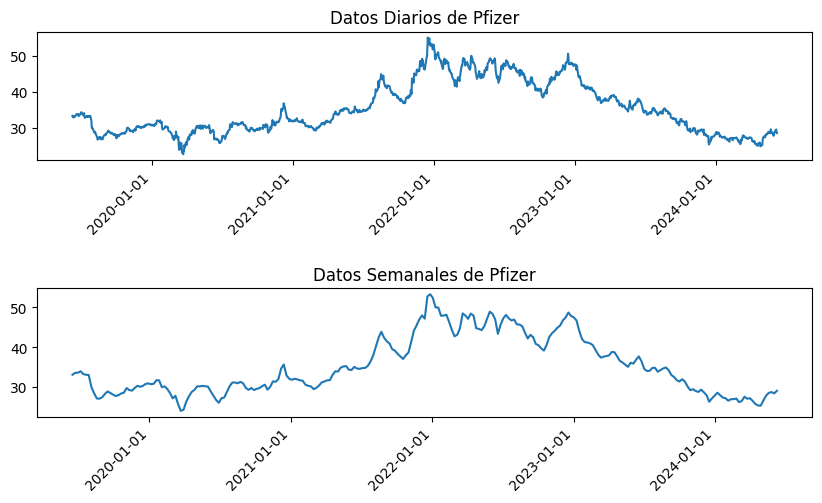

In [129]:
plot_granularity_diff(pfizer_data, 'Pfizer')

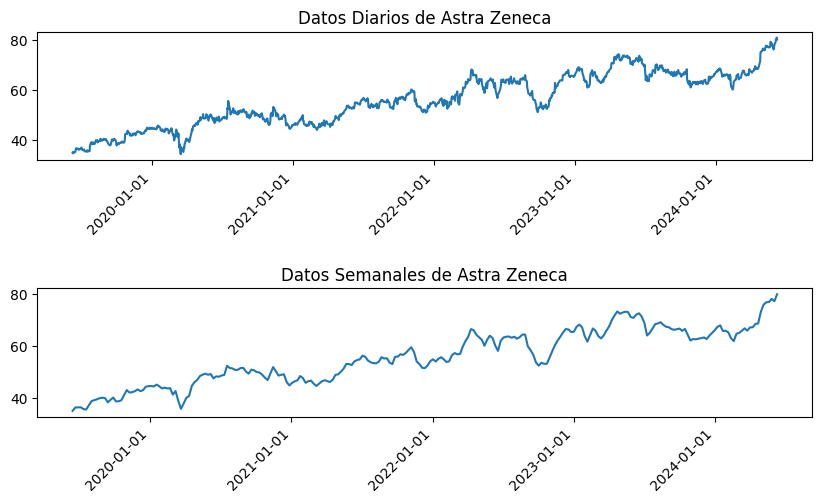

In [130]:
plot_granularity_diff(azeneca_data, 'Astra Zeneca')

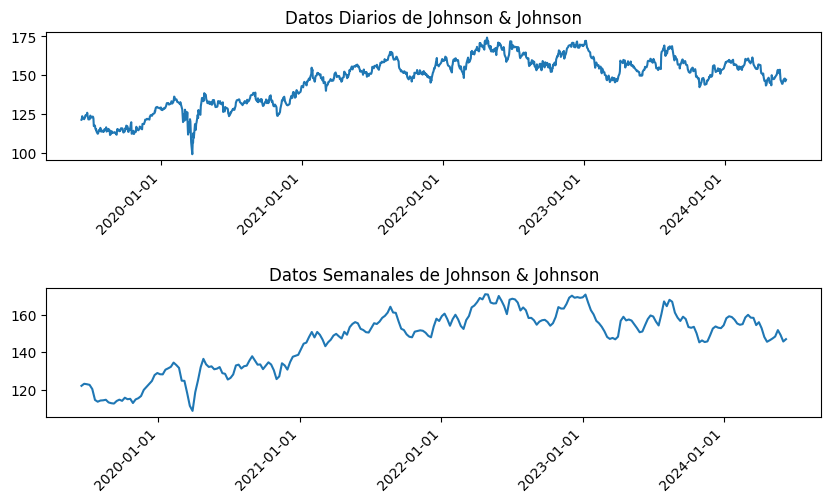

In [131]:
plot_granularity_diff(jnj_data, 'Johnson & Johnson')

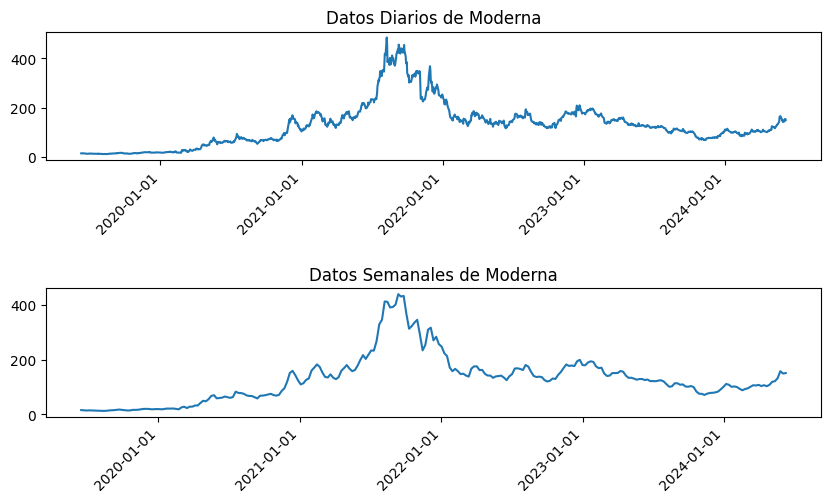

In [132]:
plot_granularity_diff(moderna_data, 'Moderna')

Se observa una disminución de la variabilidad y el número de datos en los gráficos, pues el objetivo es el de predecir en periodos medios de semanas y meses.

Además, esta reducción de variabilidad puede mejorar el rendimiento de los modelos de regresión al reducir posible ruido en las muestras.

In [133]:
pfizer_data = reduce_df_to_weekly(pfizer_data)

display(pfizer_data.head())

,Adj Close
2019-06-16,33.140615
2019-06-23,33.630446
2019-06-30,33.652563
2019-07-07,34.021876
2019-07-14,33.310895


In [134]:
moderna_data = reduce_df_to_weekly(moderna_data)

display(moderna_data.head())

,Adj Close
2019-06-16,15.814286
2019-06-23,15.090000
2019-06-30,14.265714
2019-07-07,14.826429
2019-07-14,14.397143


In [135]:
jnj_data = reduce_df_to_weekly(jnj_data)

display(jnj_data.head())

,Adj Close
2019-06-16,122.112578
2019-06-23,123.203210
2019-06-30,122.977871
2019-07-07,122.633613
2019-07-14,120.394454


In [136]:
azeneca_data = reduce_df_to_weekly(azeneca_data)

display(azeneca_data.head())

,Adj Close
2019-06-16,35.058210
2019-06-23,36.355213
2019-06-30,36.391767
2019-07-07,36.450376
2019-07-14,35.770363


### Operaciones de transformación de datos

<!-- TODO: Explicar dataframe de datos únicos (con múltiples columnas) -->
Para poder entrenar modelos de series temporales tanto univariados como multivariados, es necesario unificar los diferentes conjuntos de datos en un único conjunto total.

El conjunto de datos resultante contendrá los siguientes campos:

|Campo|Definición|
|-|-|
|`pfizer_adj_close`|Fecha de registro de precios|
|`moderna_adj_close`|Precio inicial al momento del registro|
|`azeneca_adj_close`|Precio más alto a lo largo del día|
|`jnj_adj_close` |Precio más bajo a lo largo del día|

In [137]:
combined_data = pd.concat(
    [pfizer_data, moderna_data, azeneca_data, jnj_data], 
    axis=1, 
    keys=['pfizer_adj_close', 'moderna_adj_close', 'azeneca_adj_close', 'jnj_adj_close']
)
combined_data.columns = combined_data.columns.droplevel(1)

display(combined_data.head())

,pfizer_adj_close,moderna_adj_close,azeneca_adj_close,jnj_adj_close
2019-06-16,33.140615,15.814286,35.058210,122.112578
2019-06-23,33.630446,15.090000,36.355213,123.203210
2019-06-30,33.652563,14.265714,36.391767,122.977871
2019-07-07,34.021876,14.826429,36.450376,122.633613
2019-07-14,33.310895,14.397143,35.770363,120.394454


También se busca comprobar el rendimiento de los modelos con un conjunto de datos de tipo Panel, por lo que se unificarán los datos en un único conjunto de datos.

In [138]:
import pandas as pd

data_frames = {
    'Pfizer': pfizer_data,
    'Moderna': moderna_data,
    'Azeneca': azeneca_data,
    'JNJ': jnj_data
}

dfs = []
for company, df in data_frames.items():
    df['company'] = company
    dfs.append(df.set_index(['company'], append=True))

paneled_data = pd.concat(dfs)

paneled_data.sort_index(inplace=True)

display(paneled_data.head())

Adj Close
           company            
2019-06-16 Azeneca   35.058210
           JNJ      122.112578
           Moderna   15.814286
           Pfizer    33.140615
2019-06-23 Azeneca   36.355213

Para el caso de los modelos de flujos de datos (_Data Streams_) se utilizará el conjunto de datos univariado/multivariado por sencillez.

## Análisis exploratorio de datos

### Tendencia y estacionalidad

<!-- TODO: Describir tendencia si la hubiera -->

La estacionalidad se refiere a patrones o fluctuaciones recurrentes que se observan regularmente en datos, generalmente asociados con cambios previsibles en períodos de tiempo específicos, como estaciones, trimestres o días de la semana.

Decimos que un conjunto de datos temporal demuestra estacionalidad cuando estos patrones se identifican mediante técnicas de descomposición estacional (_seasonal decompose_).

In [139]:
from statsmodels.tsa.seasonal import seasonal_decompose

En este apartado, se analizará la tendencia y comportamiento estacional de los diferentes datos disponibles, con el objetivo de comenzar a establecer qué modelos podrían ser adecuados para realizar predicciones.

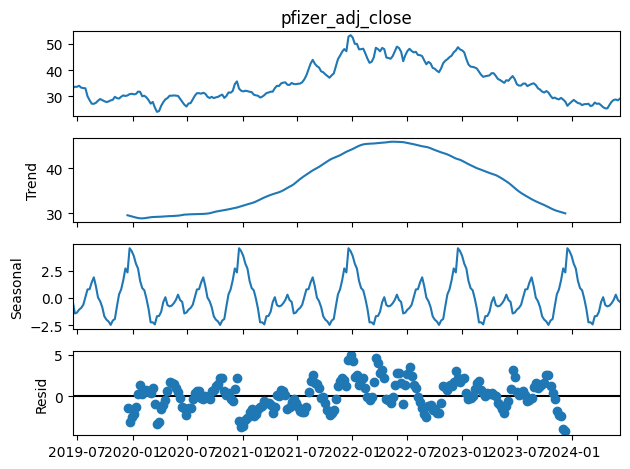

In [145]:
seasonal_decompose(combined_data['pfizer_adj_close'], model = 'additive').plot()

plt.show()

<!-- TODO: Describir estacionalidad si la hubiera -->

### Estacionariedad

<!-- TODO: Explicar qué es -->

<!-- TODO: Comprobar agdfuller sin diferenciar -->

<!-- TODO: Comprobar agdfuller diferenciando -->

### Autocorrelación (_ACF_) y autocorrelación parcial (_PACF_)

<!-- TODO: Explicar por encima correlación y autocorrelación -->

<!-- TODO: Realizar graficos -->

<!-- *: Explicar valores de ACF y PACF que importan para ARIMA -->

## Uso de series temporales

### Series univariadas

### Series multivariadas

### Series de tipo *panel*

## Uso de flujos de datos (_Data Streams_)